# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
"""
Change directory to where this file is located
"""
# %cd 'COPY&PASTE FILE DIRECTORY HERE'
%cd '/content/drive/Shareddrives/SNU VIP Lab./수업/MLDL/2023 Fall/Lab/Lab4/DL_Lab4_Practice_1206'

/content/drive/Shareddrives/SNU VIP Lab./수업/MLDL/2023 Fall/Lab/Lab4/DL_Lab4_Practice_1206


In [3]:
!pip install transformers

In [4]:
import math
import pickle
from pathlib import Path
import sys
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchtext

import pandas as pd
import numpy as np

from data.data import prepareData

In [ ]:
"""
import modules you need
"""

'\nimport modules you need\n'

In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 2.1.0+cu118, Device: cuda
Using torchtext version: 0.16.0+cpu


In [6]:
SEED = 1111

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Practice 1. Seq2seq model with Attention Mechanism

## Question 1.  Dataset

[About the Dataset]
* Translation Task
  - French(src) -> English(trg)
  - Sequence to Sequence
* Language tokens
  - src: 4,345 words in our dictionary
  - trg: 2,803 words in our dictionary
* Set max length to 10
* 10,599 pairs

In [7]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7  # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [8]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def collate_fn(self, data):
        x_batch = []; y_batch = []

        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))

        return torch.stack(x_batch), torch.stack(y_batch)

In [9]:
dataset = TranslateDataset(max_length=MAX_LENGTH)

print("\n")
print("This is data example")
print(random.choice(dataset.pairs))

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['je suis analphabete .', 'i m illiterate .']


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


In [10]:
"""
(1) Print the 1st elements of the 1st batch in the train_dataloader.

(2) Then, convert the elements into word format.
You can use dataset.input_lang.index2word and dataset.output_lang.index2word to convert the indices into words.
Any printed format is allowed if you can check the results.
"""
########## Your Code #########
x, y = next(iter(train_dataloader))
sample_x = x[0]
sample_y = y[0]
sample_x_sentence = [dataset.input_lang.index2word[i] for i in sample_x.tolist()]
sample_y_sentence = [dataset.output_lang.index2word[i] for i in sample_y.tolist()]

print("sample_x: ", sample_x) ## (1)
print(sample_x_sentence) ## (2)
print("\nsample_y: ", sample_y) ## (1)
print(sample_y_sentence) ## (2)
##############################

sample_x:  tensor([   0,   89,   24, 1595,  202, 1108,    5,    1, 4345, 4345])
['SOS', 'maintenant', 'il', 'regarde', 'la', 'tele', '.', 'EOS', 'PAD', 'PAD']

sample_y:  tensor([   0,   14,   40,  662,  595,  238,    4,    1, 2803, 2803])
['SOS', 'he', 'is', 'watching', 'tv', 'now', '.', 'EOS', 'PAD', 'PAD']



```
[answer example for Q(1) & Q(2)]
sample_x:  tensor([   0,  210,  211,  121, 2640,    5,    1, 4345, 4345, 4345])
SOS tu es tres efficace . EOS PAD PAD PAD

sample_y:  tensor([   0,  129,   78,  303, 1548,    4,    1, 2803, 2803, 2803])
SOS you re very efficient . EOS PAD PAD PAD
```



In [ ]:
"""
(3) Print the words whose indices are 0 and 1 in each dataset of input_lang and output_lang.
Check whether the indices 0 and 1 represent the same words in the input_lang and the output_lang.
You can use dataset.input_lang.index2word and dataset.output_lang.index2word to convert the indices into words.
"""
########## Your Code #########
input_lang_zero_word = dataset.input_lang.index2word[0]
output_lang_zero_word = dataset.output_lang.index2word[0]
input_lang_one_word = dataset.input_lang.index2word[1]
output_lang_one_word = dataset.output_lang.index2word[1]

print("The index 0 in each language represents....")
print(f"fra: {input_lang_zero_word}")
print(f"eng: {output_lang_zero_word}")
print("\nThe index 1 in each language represents....")
print(f"fra: {input_lang_one_word}")
print(f"eng: {output_lang_one_word}")
##############################


The index 0 in each language represents....
fra: SOS
eng: SOS

The index 1 in each language represents....
fra: EOS
eng: EOS


In [ ]:
"""
(4) Print the index of [Pad] in each dataset of input_lang and output_lang.
Check whether the input_lang and the output_lang have same index for [PAD].
"""
########## Your Code #########
input_lang_pad_idx =  dataset.input_lang.word2index['PAD']
output_lang_pad_idx = dataset.output_lang.word2index['PAD']

print("Check the indices of PAD token for each language")
print(f"fra: {input_lang_pad_idx}")
print(f"eng: {output_lang_pad_idx}")
##############################

Check the indices of PAD token for each language
fra: 4345
eng: 2803


## Question 2. Encoder

We are going to implement the Encoder part using single layer of LSTM.

In [ ]:
# Initialize Model
in_dim = dataset.input_lang.n_words # number of words in french (=4346)
out_dim = dataset.output_lang.n_words # number of word in english (=2804)
emb_dim = 512 # embbeding size
hid_dim = 256 # vector size of encoder output

print(f'\nin_dim: {in_dim}\tout_dim: {out_dim}\temb_dim: {emb_dim}\thid_dim: {hid_dim}\n')


in_dim: 4346	out_dim: 2804	emb_dim: 512	hid_dim: 256



In [ ]:
"""
(1) Try embedding the sample_x using the in_dim and emb_dim (use nn.Embedding)
Print the shapes of the embeded_x. embeded_x will be used again in Q(3).
"""
x, y = next(iter(train_dataloader))
sample_x = x[0]
print(f"sample_x: {sample_x.shape}")

########## Your Code #########
embedded_x =  nn.Embedding(in_dim, emb_dim)(sample_x)
print(f"embedded_x: {embedded_x.shape}")
##############################

sample_x: torch.Size([10])
embedded_x: torch.Size([10, 512])


In [ ]:
"""
(2) Initialize hidden and cell states for unbatched input.
You can initialize the states using torch.zeros.
Use hid_dim for their intialized sizes; Hout, Hcell.
Initialized hidden and cell states will be used again in Q(3).
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

- cell_0 : (1, hid_dim)
- hidden_0 : (1, hid_dim)
"""

########## Your Code #########
hidden_0 = torch.zeros(1, hid_dim)
cell_0 = torch.zeros(1, hid_dim)
print('Initialize hidden and cell states')
print(f'hidden_0: {hidden_0.shape}\tcell_0: {cell_0.shape}')
##############################

Initialize hidden and cell states
hidden_0: torch.Size([1, 256])	cell_0: torch.Size([1, 256])


In [ ]:
"""
(3) Get outputs of Encoder using torch.nn.LSTM.
Use embedded_x, hidden_0, cell_0 as inputs.
enc_hiddens will be used again in Decoder-Q(3) and Attention-Q(2)
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

INPUT
- embedded_x : (MAX_LENGTH, emb_dim)
- hidden_0 : (1, hid_dim)
- cell_0 : (1, hid_dim)

OUTPUT
- hiddens : (MAX_LENGTH, hid_dim)
- hidden : (1, hid_dim)
- cell : (1, hid_dim)
"""

emb_dim = 512 # embbeding size
hid_dim = 256 # vector size of encoder output

########## Your Code #########
lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim)
hiddens, (hidden, cell) =  lstm(embedded_x, (hidden_0, cell_0))

print('LSTM Encoder outputs')
print(f'hiddens: {hiddens.shape}\thidden: {hidden.shape}\tcell: {cell.shape}')
##############################

######### DO NOT MODIFY ########
print('\n')
check = ("Yes" if torch.sum(hiddens[-1]-hidden) == 0 else "No")
print(f"Is hidden equal to the last value of hiddens? : {check}")
print(f"Assigning encoder outputs for decoder (w/attention, see next question)...")
enc_hiddens = hiddens
################################

LSTM Encoder outputs
hiddens: torch.Size([10, 256])	hidden: torch.Size([1, 256])	cell: torch.Size([1, 256])


Is hidden equal to the last value of hiddens? : Yes
Assigning encoder outputs for decoder (w/attention, see next question)...


## Question 3. Decoder

We are going to implement the Decoder part using single layer of LSTM.

In [ ]:
"""
(1) Try embedding the sample_y using the given out_dim and emb_dim (Use nn.Embedding)
Print the shapes of the embedded_y.
embedded_y will be used again in Q(3).
"""

########## Your Code #########
embedded_y = nn.Embedding(out_dim, emb_dim)(sample_y)
print(f"sample_y: {sample_y.shape}")
print(f"embedded_y: {embedded_y.shape}")
##############################

sample_y: torch.Size([10])
embedded_y: torch.Size([10, 512])


In [ ]:
"""
(2) Initialize the inputs (hidden_0, cell_0, input_0) for the Decoder
They will be used again in Q(3).
Please refer to the class material of Lecture 9 for more details.
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

- cell_0 : Initialize cell state for unbatched input.
           Use hid_dim for its intialized size; Hcell. (1, hid_dim)
           You can initialize the cell state using torch.zeros.
- input_0 : (embed_dim)
- hidden_0 : (1, hid_dim)
             You have to use the output of the Encoder for hidden_0.
"""

########## Your Code #########
cell_0 = torch.zeros(1, hid_dim)
input_0 = embedded_y[0] # [SOS]
hidden_0 = enc_hiddens[-1].unsqueeze(0)
print('LSTM Decoder inputs')
print(f'input_0: {input_0.shape}\thidden_0: {hidden_0.shape}\tcell_0: {cell_0.shape}')
##############################

LSTM Decoder inputs
input_0: torch.Size([512])	hidden_0: torch.Size([1, 256])	cell_0: torch.Size([1, 256])


In [ ]:
"""
(3) Starting with the hidden_0, cell_0, input_0, apply the Decoder uing torch.nn.LSTM.
You have to compute 'seq2seq_outputs_hiddens' and 'seq2seq_outputs_index' in this question.

- 'seq2seq_outputs_index': contains indices of the predicted words
- 'seq2seq_outputs_hiddens': stacked tensors of decoded hiddens (MAX_LENGTH, 1, hid_dim)
                          It will be used again in Attention-Q(2)

Refer to the class material of Lecture 9 for details.
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
"""

seq2seq_outputs_hiddens = []
seq2seq_outputs_index = [0]  # 0: [SOS]

decoder = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim)
dec_embedder = nn.Embedding(out_dim, emb_dim)
classifier = nn.Linear(hid_dim, out_dim)
fc = nn.Linear(hid_dim + hid_dim, hid_dim)
tanh = nn.Tanh()

hidden = hidden_0
cell = cell_0
input = input_0.unsqueeze(0)

for t in range(MAX_LENGTH):
    hidden_encout_concat = torch.cat([hidden, enc_hiddens[-1].unsqueeze(0)], dim=1) # (1, 256)
    hidden = fc(hidden_encout_concat)
    hidden = tanh(hidden)

    ########## Your Code #########
    hiddens, (hidden, cell) = decoder(input, (hidden, cell))
    next_token_idx = F.softmax(classifier(hidden), dim=1).argmax()
    seq2seq_outputs_hiddens.append(hiddens)
    seq2seq_outputs_index.append(next_token_idx.item())

    # Update inputs for the next loop
    input = dec_embedder(next_token_idx).unsqueeze(0)
    ##############################

print(f'seq2seq_outputs_index : {seq2seq_outputs_index}') # predicted sentence (length 10, )
seq2seq_outputs_words = ' '.join([dataset.output_lang.index2word[i] for i in seq2seq_outputs_index])
print('\t'+seq2seq_outputs_words)
seq2seq_outputs_hiddens = torch.stack(seq2seq_outputs_hiddens)
print(f'\nseq2seq_outputs_hiddens : {seq2seq_outputs_hiddens.shape}')

seq2seq_outputs_index : [0, 1651, 1114, 1686, 2087, 2426, 2662, 506, 1725, 2732, 813]
	SOS malicious woman everybody testing unpopular months tea names holidays east

seq2seq_outputs_hiddens : torch.Size([10, 1, 256])



```
[answer example]
seq2seq_outputs_index : [0, 1375, 618, 889, 2241, 1632, 978, 789, 1482, 705, 1425]
	SOS shot embarrassed myself educated grumbling fishmonger counting near arrogant german
seq2seq_outputs_hiddens : torch.Size([10, 1, 256])
```



## Question 4. Attention

In [ ]:
"""
(1) Please apply attention mechanism to the given query, key and value.
You have to compute attention score, attention coefficient and attention value.
"""
query = torch.rand(1, 256)
key = torch.rand(10, 256)
value = torch.rand(10, 128) # query_dim = key_dim, but value_dim may be different.

########## Your Code #########
attn_score = torch.matmul(key, query.permute(1, 0))
print(attn_score.shape) # -> torch.Size([10, 1])
attn_coefficient = F.softmax(attn_score, dim=0)
print(attn_coefficient.shape) # -> torch.Size([10, 1])
attn_value = torch.sum((attn_coefficient * value), dim=0)
print(attn_value.shape) # -> torch.Size([128])
##############################

torch.Size([10, 1])
torch.Size([10, 1])
torch.Size([128])


In [ ]:
"""
(2) Please apply attention mechanism to the given query, key and value (key = value).
You have to compute attention score, attention coefficient and attention value.
"""
# key = value
kv = enc_hiddens
print("Key/value shape:\t",  kv.shape) # (10, 256)

# query
example_t = 4 # any int [0 ~ MAX_LENGTH-1]
q = seq2seq_outputs_hiddens[example_t]
print("Query shape:\t",  q.shape) # (1, 256)

########## Your Code #########
attn_score = torch.matmul(kv, q.permute(1,0))
attn_coefficient = F.softmax(attn_score, dim=0)
weighted_kv = kv * attn_coefficient
weighted_sum = torch.sum(weighted_kv, dim=0)
##############################

print("attn_score shape:\t",  attn_score.shape)
print("weights: \t", attn_coefficient.squeeze(1).tolist())
print("total of weights: \t", sum(attn_coefficient.squeeze(1).tolist()))
print("weighted sum of val:\t", weighted_kv.shape)
print("weighted sum:\t", weighted_sum.shape)

Key/value shape:	 torch.Size([10, 256])
Query shape:	 torch.Size([1, 256])
attn_score shape:	 torch.Size([10, 1])
weights: 	 [0.08134813606739044, 0.07489016652107239, 0.03244328498840332, 0.13459517061710358, 0.1534816473722458, 0.07837869226932526, 0.09667837619781494, 0.11980677396059036, 0.11790693551301956, 0.11047086864709854]
total of weights: 	 1.0000000521540642
weighted sum of val:	 torch.Size([10, 256])
weighted sum:	 torch.Size([256])


In [ ]:
sample_idx = 3  # which index of encoder output to attend [0~9]

print("before attn")
print(sum(kv[sample_idx]))
print("attn weight")
print(attn_coefficient[sample_idx])
print("after attn")
print(sum(weighted_kv[sample_idx]))

before attn
tensor(-1.5710, grad_fn=<AddBackward0>)
attn weight
tensor([0.1346], grad_fn=<SelectBackward0>)
after attn
tensor(-0.2115, grad_fn=<AddBackward0>)


# Practice 2. Vanilla Transformer


### Part 1. Dot-product similarity


In [ ]:
import torch

In [ ]:
dimension = 6
word_dictionary = {
    'I' : torch.ones(dimension),
    'am' : torch.ones(dimension)*2,
    'a' : torch.ones(dimension)*3,
    'cat' : torch.ones(dimension)*4,
    'dog' : torch.ones(dimension)*5,
}

data_1 = 'I am a cat'
data_2 = 'I am a dog'

for word, vector in word_dictionary.items():
  print(f'{word} : {vector}')

I : tensor([1., 1., 1., 1., 1., 1.])
am : tensor([2., 2., 2., 2., 2., 2.])
a : tensor([3., 3., 3., 3., 3., 3.])
cat : tensor([4., 4., 4., 4., 4., 4.])
dog : tensor([5., 5., 5., 5., 5., 5.])


Similarity between two vectors

In [ ]:
# We are going to get 'dot-product' similarity.
# Let's starts with vector-vector similarity.

token_1 = word_dictionary['I']
token_2 = word_dictionary['cat']

print(token_1)
print(token_2)

tensor([1., 1., 1., 1., 1., 1.])
tensor([4., 4., 4., 4., 4., 4.])


In [ ]:
# How to calculate similarity between token_1 & token_2?
# Answer should be a single scalar.

######### Your Answer #########
sim = token_1 @ token_2.T
###############################

print(sim.shape)
print(sim)

torch.Size([])
tensor(24.)


Similarity among vectors

In [ ]:
# Now calculate similarities among all the words in sentence,
# 'I am a cat' (data_1)

tokens = []
for word in data_1.split():
  tokens.append(word_dictionary[word])
tokens = torch.stack(tokens, dim=0)

print(tokens.shape)
print(tokens)

torch.Size([4, 6])
tensor([[1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4.]])


In [ ]:
# Answer should be [number_of_tokens x number_of_tokens] matrix.
# number_of_tokens = 4

######### Your Answer #########
sim = tokens @ tokens.T
###############################

print(sim.shape)
print(sim)

torch.Size([4, 4])
tensor([[ 6., 12., 18., 24.],
        [12., 24., 36., 48.],
        [18., 36., 54., 72.],
        [24., 48., 72., 96.]])


Similarity among vectors in batch form

In [ ]:
# Now calculate similarities among all the words in sentences,
# 'I am a cat' & 'I am a dog (data_1 & data_2) in batch form.

batch = []
for data in [data_1, data_2]:
  tokens = []
  for word in data.split():
    tokens.append(word_dictionary[word])
  tokens = torch.stack(tokens, dim=0)
  batch.append(tokens)
batch = torch.stack(batch, dim=0)

print(batch.shape)
print(batch)

torch.Size([2, 4, 6])
tensor([[[1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4., 4.]],

        [[1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3., 3.],
         [5., 5., 5., 5., 5., 5.]]])


In [ ]:
# Answer should be [batch x number_of_tokens x number_of_tokens] matrix.
# batch = 2, number_of_tokens = 4

######### Your Answer #########
# batch shape : [batch, number_of_tokens, dimension]
# sim = [batch, number_of_tokens, dimension] @ [batch, dimension, number_of_tokens]
sim = batch @ batch.transpose(-2,-1)
###############################

print(sim.shape)
print(sim)

torch.Size([2, 4, 4])
tensor([[[  6.,  12.,  18.,  24.],
         [ 12.,  24.,  36.,  48.],
         [ 18.,  36.,  54.,  72.],
         [ 24.,  48.,  72.,  96.]],

        [[  6.,  12.,  18.,  30.],
         [ 12.,  24.,  36.,  60.],
         [ 18.,  36.,  54.,  90.],
         [ 30.,  60.,  90., 150.]]])


### Part 2. Attention mechanism

In [ ]:
import torch
import torch.nn as nn

In [ ]:
dimension = 6
word_dictionary = {
    'I' : torch.ones(dimension),
    'am' : torch.ones(dimension)*2,
    'a' : torch.ones(dimension)*3,
    'cat' : torch.ones(dimension)*4,
    'dog' : torch.ones(dimension)*5,
}

data_1 = 'I am a cat'
data_2 = 'I am a dog'

for word, vector in word_dictionary.items():
  print(f'{word} : {vector}')

I : tensor([1., 1., 1., 1., 1., 1.])
am : tensor([2., 2., 2., 2., 2., 2.])
a : tensor([3., 3., 3., 3., 3., 3.])
cat : tensor([4., 4., 4., 4., 4., 4.])
dog : tensor([5., 5., 5., 5., 5., 5.])


In [ ]:
batch = []
for data in [data_1, data_2]:
  tokens = []
  for word in data.split():
    tokens.append(word_dictionary[word])
  tokens = torch.stack(tokens, dim=0)
  batch.append(tokens)
batch = torch.stack(batch, dim=0)

print(batch.shape)
print(batch)

torch.Size([2, 4, 6])
tensor([[[1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4., 4.]],

        [[1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3., 3.],
         [5., 5., 5., 5., 5., 5.]]])


In [ ]:
# batch shape : [batch, number_of_tokens, dimension]
# Use nn.Linear to make Query, Key & Value.
# Remember, there will be no change in shape of tensor.

to_query = nn.Linear(dimension, dimension)
to_key = nn.Linear(dimension, dimension)
to_value = nn.Linear(dimension, dimension)

query = to_query(batch)
key = to_key(batch)
value = to_value(batch)

print(f'Query : {query.shape}')
print(f'Key : {key.shape}')
print(f'Value : {value.shape}')

Query : torch.Size([2, 4, 6])
Key : torch.Size([2, 4, 6])
Value : torch.Size([2, 4, 6])


In [ ]:
# Implement attention mechanism
# As you've done in part 1,
# attention_score should be [batch x number_of_tokens x number_of_tokens]
# contextualized_tokens should be [batch, number_of_tokens, dimension]

attention_score = query @ key.transpose(-2,-1)
attention_score = attention_score.softmax(dim=-1)

contextualized_tokens = attention_score @ value

print(f'attention_score : {attention_score.shape}')
print(f'contextualized_tokens : {contextualized_tokens.shape}')

attention_score : torch.Size([2, 4, 4])
contextualized_tokens : torch.Size([2, 4, 6])


### Part 3. Positional Encoding & Masking



In [ ]:
# initialize model
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
emb_dim = 256
MAX_LENGTH = 10

In [ ]:
# embedding input
embedded_x = nn.Embedding(in_dim, emb_dim)(sample_x)
print("embedded_x:\t", embedded_x.shape)

embedded_x:	 torch.Size([10, 256])


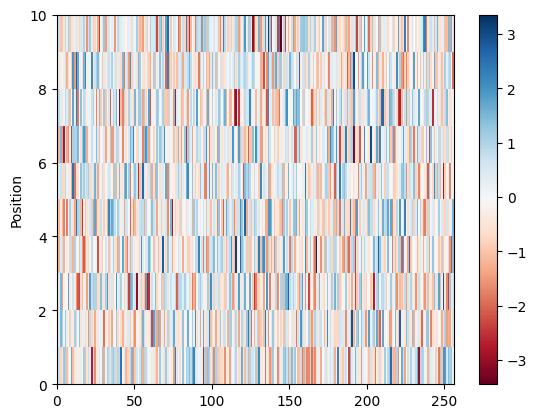

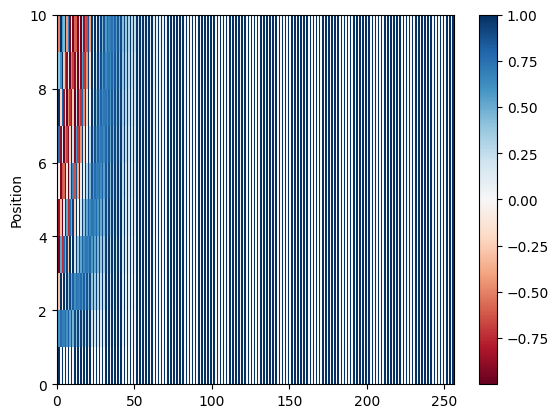

In [ ]:
"""
(1) Positional Encoding

(1)-a : Make the Learnable Embedding (using nn.Embedding) and Visualize it using matplotlib.pyplot.pcolormesh.

(1)-b : Absolute sinusoid-baesd Positinal Encoding is given in the file of pe_fall22.pickle.
Visualize it using matplotlib.pyplot.pcolormesh.

Please refer to the images sinusoid.png & learnable.png in data directory as answer exmples.
"""
import matplotlib.pyplot as plt

########## Your Code #########
# a. Learnable Embedding (using nn.Embedding)
pos = torch.arange(MAX_LENGTH).unsqueeze(1)
pos_embedding = nn.Embedding(in_dim, emb_dim)(pos)
plt.pcolormesh(pos_embedding.squeeze(1).detach().numpy(), cmap='RdBu') # Learnable
plt.xlim((0, emb_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# b. Absolute sinusoid-baesd Positinal Encoding
with open('./data/pe_fall22.pickle', 'rb') as handle:
  pe = pickle.load(handle)
plt.pcolormesh(pe.squeeze(1), cmap='RdBu')
plt.xlim((0, emb_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##############################




In [ ]:
"""
(2) Make the Source Masking for the sample_x
Source Masking is a tensor of shape (MAX_LENGTH), in which Padded tokens are True, and the rest of the tokens are False.
"""
x, y = next(iter(train_dataloader))
sample_x = x[0]

########## Your Code #########
source_mask = (sample_x == dataset.input_lang_pad) # [PAD]

print("source mask = pad masking")
print(source_mask.squeeze().tolist())
##############################

source mask = pad masking
[False, False, False, False, False, False, False, False, True, True]


In [ ]:
"""
(2) Make the Target Maskings for the sample_y.

(2)-1 : pad_mask_neg
pad_mask_neg is a tensor of shape (MAX_LENGTH), in which Padded tokens are False, and the rest of the tokens are True.

(2)-2 : sub_mask
sub_mask is a tensor of shape (MAX_LENGTH, MAX_LENGTH), in which only the tokens of the current timestep are True.
You can use torch.tril function.

(2)-3 : target mask (MAX_LENGTH, MAX_LENGTH)
target mask is a tensor of shape  (MAX_LENGTH, MAX_LENGTH),
in which both of the not-padded tokens and the tokens of the current timestep are True.

"""
x, y = next(iter(train_dataloader))
sample_y = y[0]

########## Your Code #########
pad_mask_neg = (sample_y != dataset.output_lang_pad).unsqueeze(1)
sub_mask = torch.tril(torch.ones((MAX_LENGTH, MAX_LENGTH))).bool()
target_mask = pad_mask_neg.permute(1,0) & sub_mask

print("\ntarget mask = pad masking + subsequent masking")
print(pad_mask_neg.squeeze().tolist())
print()
print(sub_mask.squeeze())
print()
print(target_mask.squeeze())
##############################


target mask = pad masking + subsequent masking
[True, True, True, True, True, True, True, True, True, False]

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

tensor([[ True, False, False, False, False, False, False, False, False, False],
       

OUTPUT EXAMPLE
```
target mask = pad masking + subsequent masking
[True, True, True, True, True, True, False, False, False, False]

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False]])
```



### Part 4. Implement Seq2Seq model with Transformer


In [ ]:
"""
(3) Implement Seq2seq model with Transformer
"""

from torch.nn import Transformer ## 과제에서는 사용하면 안됨

class TransSeq2Seq(nn.Module):
    def __init__(self, hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p):
        super().__init__()
        """
        - Define self.input_emb and self.output_emb layer same as in Q(2) and Q(3).
        - self.dropout will be used after adding the embedded_pos to the embedded_x and embedded_y.
        - use 'gelu' for activation function in Transformer layer
        """
        self.input_emb = nn.Embedding(in_dim, hid_dim)
        self.output_emb = nn.Embedding(out_dim, hid_dim)
        self.pos_emb = nn.Embedding(MAX_LENGTH, hid_dim)
        ########## Your Code #########
        self.transformer = Transformer(d_model=hid_dim,
                                       nhead=n_heads,
                                       num_encoder_layers=n_enc_layers,
                                       num_decoder_layers=n_dec_layers,
                                       dim_feedforward = ff_dim,
                                       dropout = dropout_p,
                                       activation = 'gelu')
        self.dropout = nn.Dropout(dropout_p)
        ##############################

    def forward(self, src, trg):
        """
        1) Get the embedded_x using self.input_emb and src (source)
        2) Get the embedded_y using self.input_emb and trg (target)
        3) Get the embedded_pos using self.pos_emb
        4) Apply the dropout to embedded_x and embedded_y
        5) Get the output using self.transformer
        """
        ########## Your Code #########
        embedded_pos =  self.pos_emb(torch.arange(MAX_LENGTH))
        embedded_x = self.input_emb(src)
        embedded_y = self.output_emb(trg)

        embedded_x = self.dropout(embedded_x + embedded_pos)
        embedded_y = self.dropout(embedded_y + embedded_pos)
        output = self.transformer(embedded_x, embedded_y)

        return output
        ##############################



In [ ]:
"""
(4) Define the Transformer model.
Compute and print the output of the model using sample_x and sample_y as inputs.
"""
########## Your Code #########
emb_dim = 256
hid_dim = emb_dim
ff_dim = 1024
n_heads = 8
n_enc_layers = 3
n_dec_layers = 5
dropout_p = 0.1

model = TransSeq2Seq(hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p)
output = model(sample_x, sample_y)
print(output.shape) # (10, 256)
##############################

torch.Size([10, 256])
